In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '/Users/tareen/Desktop/Research_Projects/2022_mavenn2_github/mavenn')

import mavenn
import logomaker
import seaborn as sns
import re

%matplotlib inline

In [2]:
binding_df_full = pd.read_csv('data/GRB2-SH3.binding.csv')
binding_df = binding_df_full[['aa_seq','count_e1_s0','count_e1_s1']].dropna().reset_index(drop=True).copy()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
abundance_df = pd.read_csv('data/GRB2-SH3.abundance.csv')
abundance_df = abundance_df[['aa_seq','count_e1_s0','count_e1_s1']].dropna().reset_index(drop=True).copy()

In [4]:
data_df = binding_df.copy()
y_cols = data_df.columns[1:] 

In [5]:
X = data_df['aa_seq']
y = data_df[y_cols]

In [6]:
# set positional argumnets for gpmap function
L = len(data_df['aa_seq'][0])
alphabet=['A', 'C', 'D', 'E', 'F',
          'G', 'H', 'I', 'K', 'L',
          'M', 'N', 'P', 'Q', 'R',
          'S', 'T', 'V', 'W', 'Y', '*']


Y = len(y_cols)
print(f'L={L}, Y={Y}')

L=57, Y=2


In [7]:
gpmap_binding_DM = mavenn.gpmap.AdditiveGPMapLayer(L, alphabet)
gpmap_binding_EE = mavenn.gpmap.AdditiveGPMapLayer(L, alphabet)

gpmap_abundance = mavenn.gpmap.AdditiveGPMapLayer(L, alphabet)

# # instantiate gpmap object
# gpmap = mavenn.gpmap.Multi_AdditiveGPMapLayer(L=L, 
#                                               alphabet=alphabet,
#                                               number_latent_nodes=2)



2022-12-02 14:40:38.460984: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
from sklearn.model_selection import train_test_split

# split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [9]:
def model_local(gpmap, 
                mp,
                x_train,
                y_train):
    
    model = mavenn.Model2(gpmap=gpmap,
                          mp_list=[mp])
    
    # Set training data
    model.set_data(x=x_train.values,
                   y_list=[y_train.values],
                   shuffle=True)
    
    return model
    

In [10]:
mp_DM = mavenn.measurement_process_layers.DiscreteMonotonicMP(info_for_layers_dict={'H_y_norm':0},
                                                               Y=Y,
                                                               K=50,
                                                               eta=1e-5,)


mp_EE = mavenn.measurement_process_layers.ExponentialEnrichmentMP(Y=Y,
                                                                  t_y=[0,1],
                                                                  eta=1e-5,
                                                                  info_for_layers_dict={'H_y_norm':0})


In [11]:
model_binding_DM = model_local(gpmap_binding_DM,mp_DM, x_train, y_train)
model_binding_EE = model_local(gpmap_binding_EE,mp_EE, x_train, y_train)

N = 38,449 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 3.37 sec.
N = 38,449 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 2.96 sec.


In [12]:
# # Set training data
# model.set_data(x=x_train.values,
#                y_list=[y_train.values],
#                shuffle=True)


In [13]:
# from tensorflow.keras.utils import plot_model
# plot_model(model.model,show_shapes=True,show_dtype=False,dpi=300,to_file='lehner.png')

In [14]:

# Fit model to data
model_binding_DM.fit(learning_rate=.0005,
                     epochs=300,
                     batch_size=300,
                     try_tqdm = False,
                     early_stopping=False,
                     verbose=False,
                     early_stopping_patience=10,
                     linear_initialization=False)

model_binding_EE.fit(learning_rate=.0005,
                     epochs=300,
                     batch_size=300,
                     try_tqdm = False,
                     early_stopping=False,
                     verbose=False,
                     early_stopping_patience=10,
                     linear_initialization=False)

Training time: 202.0 seconds
Training time: 147.2 seconds


On test data:


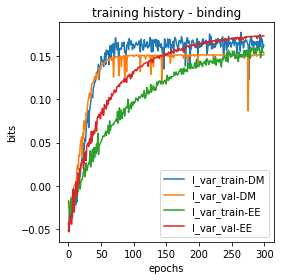

In [15]:
# Show training history
print('On test data:')
# x_test = test_df['x'].values
# y_test = test_df[y_cols].values


I_var_hist = model_binding_DM.history['I_var']
val_I_var_hist = model_binding_DM.history['val_I_var']

fig, ax = plt.subplots(figsize=[4,4])

ax.plot(I_var_hist, label='I_var_train-DM')
ax.plot(val_I_var_hist, label='I_var_val-DM')
#ax.set_xscale('log')
ax.set_title('training history - binding')

I_var_hist = model_binding_EE.history['I_var']
val_I_var_hist = model_binding_EE.history['val_I_var']

ax.plot(I_var_hist, label='I_var_train-EE')
ax.plot(val_I_var_hist, label='I_var_val-EE')

ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('bits')

fig.tight_layout()
fig.savefig('plots/GRB2_SH3/training_history_binding.png',dpi=200,bbox_inches='tight')


In [16]:
phi_DM = gpmap_binding_DM.x_to_phi(x_test)
phi_EE = gpmap_binding_EE.x_to_phi(x_test)

In [17]:
theta_lc_DM = gpmap_binding_DM.get_theta(model_binding_DM,gauge='consensus')['theta_lc']
theta_lc_EE = gpmap_binding_EE.get_theta(model_binding_EE,gauge='consensus')['theta_lc']
theta_lc_consensus_EE_df = pd.DataFrame(theta_lc_EE,columns=alphabet)
theta_lc_consensus_DM_df = pd.DataFrame(theta_lc_DM,columns=alphabet)

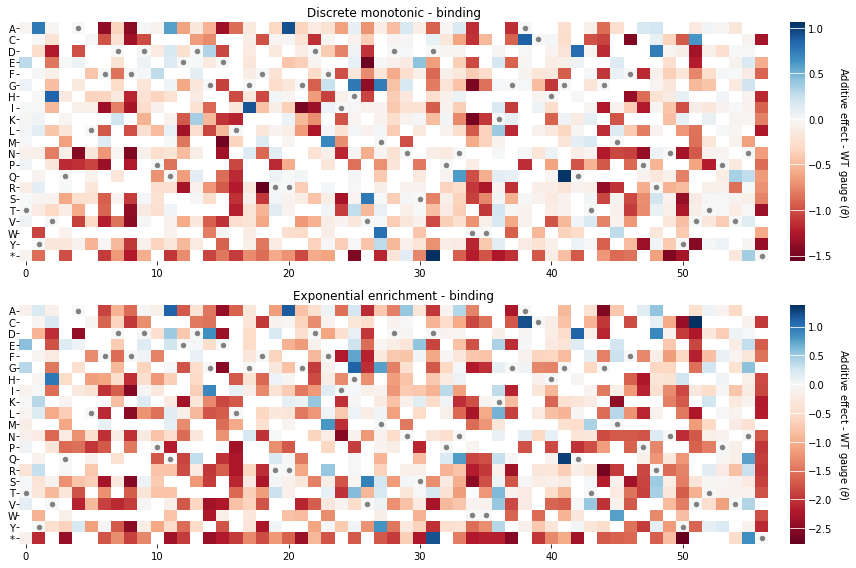

In [18]:

# # Create fig and ax objects
fig, axs = plt.subplots(2,1, figsize=[12,8])

ax = axs[0]
# Draw heatmap
ax, cb = mavenn.heatmap(ax=ax,
                        values=theta_lc_DM,
                        alphabet=alphabet,
                        seq=model_binding_DM.x_stats['consensus_seq'],
                        seq_kwargs={'c':'gray', 's':20,'marker':'o'},
                        cmap='RdBu',
                        cbar=True,
                        #clim = [-5,1],
                        cmap_size='2%',
                        cmap_pad=.3,
                        ccenter=0)

# Style colorbar
cb.set_label('Additive effect - WT gauge ($\\theta$)',
             labelpad=10, ha='center', va='center', rotation=-90)
cb.outline.set_visible(False)
cb.ax.tick_params(direction='in', size=20, color='white')
ax.set_title('Discrete monotonic - binding')

ax = axs[1]
# Draw heatmap
ax, cb = mavenn.heatmap(ax=ax,
                        values=theta_lc_EE,
                        alphabet=alphabet,
                        seq=model_binding_EE.x_stats['consensus_seq'],
                        seq_kwargs={'c':'gray', 's':20,'marker':'o'},
                        cmap='RdBu',
                        cbar=True,
                        #clim = [-5,1],
                        cmap_size='2%',
                        cmap_pad=.3,
                        ccenter=0)

# Style colorbar
cb.set_label('Additive effect - WT gauge ($\\theta$)',
             labelpad=10, ha='center', va='center', rotation=-90)
cb.outline.set_visible(False)
cb.ax.tick_params(direction='in', size=20, color='white')
ax.set_title('Exponential enrichment - binding')


fig.tight_layout()
fig.savefig('plots/GRB2_SH3/GP_map_binding.png',dpi=300,bbox_inches='tight')

Text(0, 0.5, 'Theta exponential enrichment')

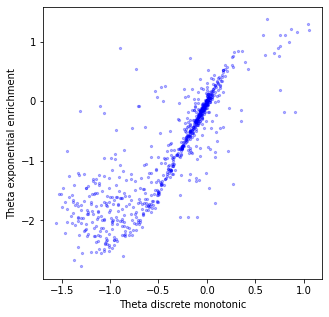

In [19]:
plt.figure(figsize=(5,5))
plt.scatter(theta_lc_DM.ravel(),theta_lc_EE.ravel(),c='blue',s=5,alpha=0.3)
plt.xlabel('Theta discrete monotonic')
plt.ylabel('Theta exponential enrichment')

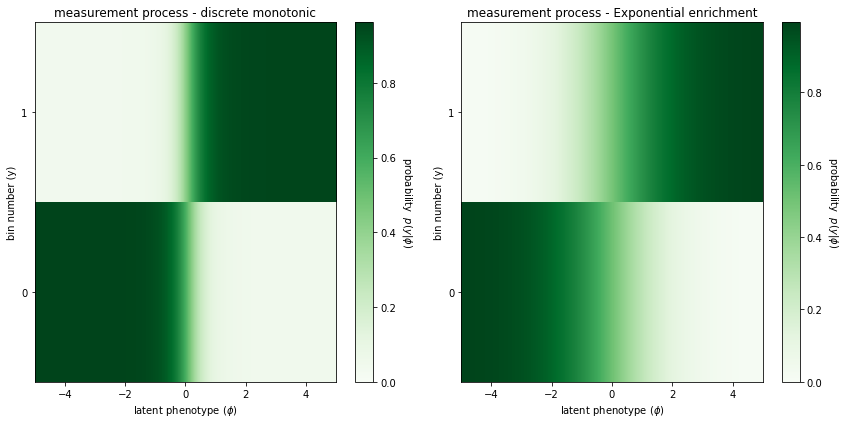

In [20]:
# Create grid in phi space
phi_lim = [-5, 5]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Create array of allowable y values
Y = mp_DM.Y    # Y = number of bins
y_lim = [-.5, Y-.5]
y_all = range(Y)

# Compute matrix of p(y|phi) values



# Create figure with two panels
fig, axs = plt.subplots(1,2,figsize=[12,6])

ax = axs[0]
# Right panel: draw measurement process as heatmap

measurement_process = mp_DM.p_of_y_given_phi(y_all, phi_grid)
im = ax.imshow(measurement_process,
               cmap='Greens',
               extent=phi_lim+y_lim,
               vmin=0,
               origin='lower',
               interpolation='nearest',
               aspect="auto")
ax.set_yticks(y_all)
ax.set_ylabel('bin number (y)')
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_title('measurement process - discrete monotonic')
cb = plt.colorbar(im,ax=ax)
cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")

ax = axs[1]
# Right panel: draw measurement process as heatmap

measurement_process = mp_EE.p_of_y_given_phi(y_all, phi_grid)
im = ax.imshow(measurement_process,
               cmap='Greens',
               extent=phi_lim+y_lim,
               vmin=0,
               origin='lower',
               interpolation='nearest',
               aspect="auto")
ax.set_yticks(y_all)
ax.set_ylabel('bin number (y)')
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_title('measurement process - Exponential enrichment')
cb = plt.colorbar(im,ax=ax)
cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")


fig.tight_layout()
fig.savefig('plots/GRB2_SH3/lehner_measurment_prcoess_binding.png',dpi=300,bbox_inches='tight')


In [21]:
data_df_GE = binding_df_full[['aa_seq','fitness']].copy()

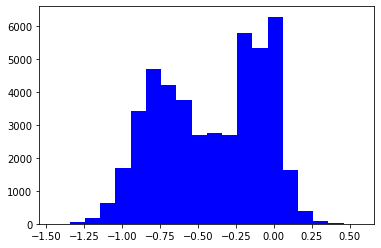

In [22]:
plt.hist(data_df_GE['fitness'],bins=20,color='blue')
plt.show()

In [23]:
gpmapGE = mavenn.gpmap.AdditiveGPMapLayer(L, alphabet)
mp_GE = mavenn.measurement_process_layers.GlobalEpsitasisMP(K=50,
                                                           monotonic=True,
                                                           ge_heteroskedasticity_order=2,
                                                           ge_noise_model_type='Gaussian')

In [24]:
from sklearn.model_selection import train_test_split

# split data into training and testing sets
x_train_GE, x_test_GE, y_train_GE, y_test_GE = train_test_split(data_df_GE['aa_seq'].values, 
                                                                data_df_GE['fitness'].values, test_size=0.1)

In [25]:
model_GE = mavenn.Model2(gpmap=gpmapGE,
                      mp_list=[mp_GE])

# Set training data
model_GE.set_data(x=x_train_GE,
               #y_list=[data_df['y'].values.reshape(-1,1)],
               y_list=[y_train_GE.reshape(-1,1)],
               shuffle=False)

N = 41,749 observations set as training data.
Using 19.8% for validation.
Time to set data: 1.32 sec.


In [26]:
# Fit model to data
history = model_GE.fit(learning_rate=.0005,
                    epochs=150,
                    batch_size=300,
                    try_tqdm=False,
                    early_stopping=False,
                    early_stopping_patience=5,
                    linear_initialization=False)

Epoch 1/150
112/112 [==============================] - 1s 4ms/step - loss: 276.1555 - I_var: -1.1089 - val_loss: 256.8932 - val_I_var: -1.0256
Epoch 2/150
112/112 [==============================] - 0s 3ms/step - loss: 246.3425 - I_var: -0.9654 - val_loss: 231.2460 - val_I_var: -0.9013
Epoch 3/150
112/112 [==============================] - 0s 3ms/step - loss: 222.1363 - I_var: -0.8487 - val_loss: 208.6376 - val_I_var: -0.7917
Epoch 4/150
112/112 [==============================] - 0s 3ms/step - loss: 200.9599 - I_var: -0.7469 - val_loss: 189.2097 - val_I_var: -0.6975
Epoch 5/150
112/112 [==============================] - 0s 3ms/step - loss: 182.0651 - I_var: -0.6557 - val_loss: 170.3313 - val_I_var: -0.6059
Epoch 6/150
112/112 [==============================] - 0s 3ms/step - loss: 158.4814 - I_var: -0.5419 - val_loss: 140.2261 - val_I_var: -0.4587
Epoch 7/150
112/112 [==============================] - 0s 3ms/step - loss: 121.7155 - I_var: -0.3648 - val_loss: 102.6553 - val_I_var: -0.2766

112/112 [==============================] - 0s 3ms/step - loss: -175.6209 - I_var: 1.0679 - val_loss: -163.8080 - val_I_var: 1.0137
Epoch 59/150
112/112 [==============================] - 0s 3ms/step - loss: -175.6476 - I_var: 1.0681 - val_loss: -165.4262 - val_I_var: 1.0214
Epoch 60/150
112/112 [==============================] - 0s 3ms/step - loss: -176.4526 - I_var: 1.0724 - val_loss: -165.7214 - val_I_var: 1.0227
Epoch 61/150
112/112 [==============================] - 0s 3ms/step - loss: -176.7901 - I_var: 1.0727 - val_loss: -165.3885 - val_I_var: 1.0211
Epoch 62/150
112/112 [==============================] - 0s 3ms/step - loss: -177.4139 - I_var: 1.0762 - val_loss: -162.3531 - val_I_var: 1.0062
Epoch 63/150
112/112 [==============================] - 0s 3ms/step - loss: -178.0303 - I_var: 1.0798 - val_loss: -162.6450 - val_I_var: 1.0078
Epoch 64/150
112/112 [==============================] - 0s 3ms/step - loss: -177.8815 - I_var: 1.0792 - val_loss: -163.1777 - val_I_var: 1.0105
Epoch

Epoch 115/150
112/112 [==============================] - 0s 3ms/step - loss: -182.8777 - I_var: 1.1020 - val_loss: -165.3510 - val_I_var: 1.0225
Epoch 116/150
112/112 [==============================] - 0s 3ms/step - loss: -183.3293 - I_var: 1.1044 - val_loss: -163.9081 - val_I_var: 1.0156
Epoch 117/150
112/112 [==============================] - 0s 3ms/step - loss: -182.9145 - I_var: 1.1029 - val_loss: -163.8983 - val_I_var: 1.0156
Epoch 118/150
112/112 [==============================] - 0s 3ms/step - loss: -183.4930 - I_var: 1.1064 - val_loss: -156.2287 - val_I_var: 0.9783
Epoch 119/150
112/112 [==============================] - 0s 3ms/step - loss: -182.4321 - I_var: 1.1003 - val_loss: -164.6682 - val_I_var: 1.0193
Epoch 120/150
112/112 [==============================] - 0s 3ms/step - loss: -183.5167 - I_var: 1.1060 - val_loss: -164.8251 - val_I_var: 1.0202
Epoch 121/150
112/112 [==============================] - 0s 3ms/step - loss: -183.4591 - I_var: 1.1059 - val_loss: -165.4969 - val

On test data:


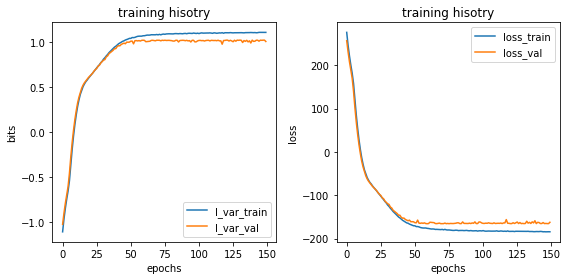

In [27]:
# Show training history
print('On test data:')
# x_test = test_df['x'].values
# y_test = test_df[y_cols].values


I_var_hist = model_GE.history['I_var']
val_I_var_hist = model_GE.history['val_I_var']

fig, axs = plt.subplots(1,2,figsize=[8,4])

ax = axs[0]
ax.plot(I_var_hist, label='I_var_train')
ax.plot(val_I_var_hist, label='I_var_val')
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
#ax.set_xscale('log')
ax.set_title('training hisotry')

ax = axs[1]
ax.plot(model_GE.history['loss'], label='loss_train')
ax.plot(model_GE.history['val_loss'], label='loss_val')
# ax.set_xlim(100,300)
# ax.set_ylim(0.7*1e6,0.8*1e6)
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('loss')
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_title('training hisotry')
fig.tight_layout()

In [28]:
phi = gpmapGE.x_to_phi(x_test_GE)

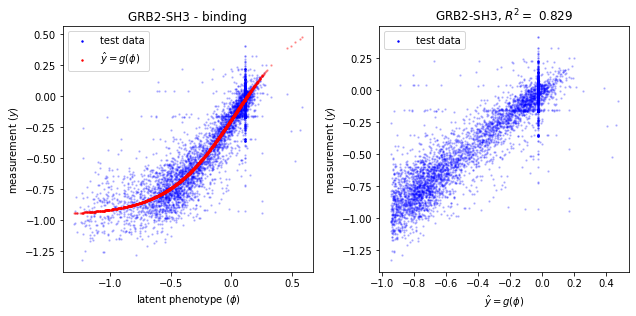

In [29]:
fig, axs = plt.subplots(1,2, figsize=(9,4.5))

ax = axs[0]
yhat = mp_GE.phi_to_yhat(phi)
ax.scatter(phi,y_test_GE,s=2,alpha=0.2,c='b',label='test data')
#ax.scatter(phi,yhat* model.y_std+model.y_mean,s=1,alpha=0.1,c='r',label='$\hat{y} = g(\phi)$')
ax.scatter(phi,yhat,s=2,alpha=0.3,c='r',label='$\hat{y} = g(\phi)$')

ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_ylabel('measurement ($y$)')
ax.set_title('GRB2-SH3 - binding')
leg = ax.legend()

for lh in leg.legendHandles: 
    lh.set_alpha(1)
    
    
ax = axs[1]
ax.scatter(yhat,y_test_GE,s=2,alpha=0.2,c='b',label='test data')
Rsq = np.corrcoef(yhat.numpy().ravel(),y_test_GE)[0,1]**2

ax.set_xlabel('$\hat{y} = g(\phi)$')
ax.set_ylabel('measurement ($y$)')
ax.set_title(f'GRB2-SH3, $R^2 = $ {Rsq:.3f}')
leg = ax.legend()

for lh in leg.legendHandles: 
    lh.set_alpha(1)

fig.tight_layout()
fig.savefig('plots/GRB2_SH3/global_epistasis_binding_binding.png',dpi=300,bbox_inches='tight')    


In [30]:
theta_lc_GE = gpmapGE.get_theta(model_GE,gauge='consensus')['theta_lc']

Text(0, 0.5, 'Theta global epistasis')

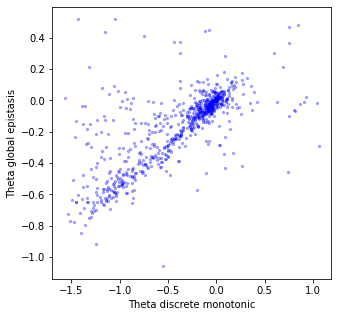

In [31]:
plt.figure(figsize=(5,5))
plt.scatter(theta_lc_DM.ravel(),theta_lc_GE.ravel(),c='blue',s=5,alpha=0.3)
plt.xlabel('Theta discrete monotonic')
plt.ylabel('Theta global epistasis')

In [32]:
lehner_binding_singles_df = pd.read_csv('data/GRB2-SH3.singles_binding.csv')
lehner_binding_singles_df

,Unnamed: 0,Pos,WT_AA,Mut,nt_seq,aa_seq,Nham_nt,Nham_aa,Nmut_codons,STOP,STOP_readthrough,mean_count,fitness,sigma
0,1,1,T,K,NaN,KYVQALFDFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...,NaN,1,1,False,False,2181.666667,0.010464,0.005995
1,2,1,T,N,NaN,NYVQALFDFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...,NaN,1,1,False,False,16.000000,0.028944,0.087284
2,3,2,Y,K,NaN,TKVQALFDFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...,NaN,1,1,False,False,23.000000,-0.093964,0.092442
3,4,2,Y,N,NaN,TNVQALFDFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...,NaN,1,1,False,False,8892.666667,-0.035080,0.004516
4,5,2,Y,S,NaN,TSVQALFDFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...,NaN,1,1,False,False,54.666667,0.044625,0.027825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
706,707,1,T,A,NaN,AYVQALFDFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...,NaN,1,1,False,False,11058.666667,-0.013506,0.004341
707,708,1,T,G,NaN,GYVQALFDFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...,NaN,1,1,False,False,14.000000,-0.012349,0.071471
708,709,1,T,V,NaN,VYVQALFDFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...,NaN,1,1,False,False,57.000000,-0.002641,0.028864
709,710,1,T,*,NaN,*YVQALFDFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...,NaN,1,1,True,False,15.000000,-0.219692,0.074135


In [33]:
binding_singles_transformed_df = pd.DataFrame(np.nan*np.ones(shape=(57,21)),columns=alphabet)
binding_singles_transformed_df.head()

,A,C,D,E,F,G,H,I,K,L,...,N,P,Q,R,S,T,V,W,Y,*
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
for idx in lehner_binding_singles_df.index:

    mutant = lehner_binding_singles_df.loc[idx]['Mut']
    value = lehner_binding_singles_df.loc[idx]['fitness']
    
    pos = lehner_binding_singles_df.loc[idx]['Pos']-1
    binding_singles_transformed_df[mutant][pos] = value

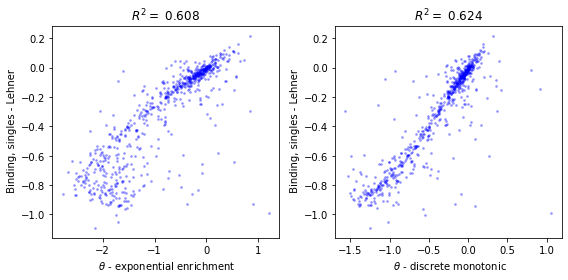

In [35]:
fig, axs = plt.subplots(1,2,figsize=(8,4))

ax = axs[0]
Rsq = np.corrcoef(theta_lc_consensus_EE_df.fillna(0).values.ravel(),binding_singles_transformed_df.fillna(0).values.ravel())[0,1]**2
ax.scatter(theta_lc_consensus_EE_df.values.ravel(),binding_singles_transformed_df.values.ravel(),s=3,alpha=0.3,color='blue')
ax.set_xlabel(' $\\theta$ - exponential enrichment')
ax.set_ylabel(' Binding, singles - Lehner')
ax.set_title(f'$R^2 = $ {Rsq:.3f}')

ax = axs[1]
Rsq = np.corrcoef(theta_lc_consensus_DM_df.fillna(0).values.ravel(),binding_singles_transformed_df.fillna(0).values.ravel())[0,1]**2
ax.scatter(theta_lc_consensus_DM_df.values.ravel(),binding_singles_transformed_df.values.ravel(),s=3,alpha=0.3,color='blue')
ax.set_xlabel(' $\\theta$ - discrete monotonic')
ax.set_ylabel(' Binding, singles - Lehner')
ax.set_title(f'$R^2 = $ {Rsq:.3f}')

fig.tight_layout()

fig.savefig('plots/GRB2_SH3/GRB2_SH3.singles_binding_comparison_to_Lehner.png',dpi=200,bbox_inches='tight')


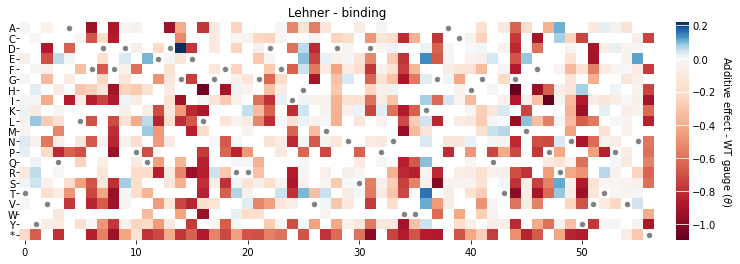

In [36]:
# # Create fig and ax objects
fig, ax = plt.subplots(figsize=[12,4])

# Draw heatmap
ax, cb = mavenn.heatmap(ax=ax,
                        values=binding_singles_transformed_df.values,
                        alphabet=alphabet,
                        seq=model_binding_DM.x_stats['consensus_seq'],
                        seq_kwargs={'c':'gray', 's':20,'marker':'o'},
                        cmap='RdBu',
                        cbar=True,
                        #clim = [-5,1],
                        cmap_size='2%',
                        cmap_pad=.3,
                        ccenter=0)

# Style colorbar
cb.set_label('Additive effect - WT gauge ($\\theta$)',
             labelpad=10, ha='center', va='center', rotation=-90)
cb.outline.set_visible(False)
cb.ax.tick_params(direction='in', size=20, color='white')
ax.set_title('Lehner - binding')

fig.savefig('plots/GRB2_SH3/Lehner_GP_map_binding.png',dpi=300,bbox_inches='tight')

In [37]:
abundance_data_df_GE = pd.read_csv('abundance_lehner_GE.csv',index_col=[0])
abundance_data_df_GE.columns = ['aa_seq','abundance_fitness']
abundance_data_df_GE

,aa_seq,abundance_fitness
0,NYVQALFDFRPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...,0.014463
1,NYVQALFDFDTQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...,-0.161291
2,NYVQALFDFDPQEDEELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...,-0.359899
3,NYVQALFDFDPQEDGELGRRRGDFIHVMDNSDPNWWKGACHGQTGM...,-1.348834
4,NYVQALFDFDPQEDGELGGRRGDFIHVMDNSDPNWWKGACHGQTGM...,-1.164175
...,...,...
69739,MYVQALFVFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...,-0.923700
69740,MYVQALF*FDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...,-1.104500
69741,MYVQALFCFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...,-1.097747
69742,MYVQYLFDFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...,-1.181016


In [38]:
len(abundance_data_df_GE['aa_seq'].values[0])

57

In [39]:
#len(data_df_GE['aa_seq'].values
same_seqs = np.intersect1d(data_df_GE['aa_seq'].values,abundance_data_df_GE['aa_seq'].values)

In [40]:
same_seqs_binding_df = data_df_GE[data_df_GE['aa_seq'].isin(same_seqs)].reset_index(drop=True)
same_seqs_abundance_df = abundance_data_df_GE[abundance_data_df_GE['aa_seq'].isin(same_seqs)].reset_index(drop=True)


In [41]:
same_seqs_binding_df['aa_seq']

0        KYVQALFDFEPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...
1        KYVQALFDFDPQEDGELGFSRGDFIHVMDNSDPNWWKGACHGQTGM...
2        KYVQALFDFDPQEDGELGFRRGDFIHAMDNSDPNWWKGACHGQTGM...
3        KYVQALFDFDPQEDGELGFRRGDFIHVKDNSDPNWWKGACHGQTGM...
4        KYVQALFDFDPQEDGELGFRRGDFIHVMDNSDPN*WKGACHGQTGM...
                               ...                        
13835    SYVQALFVFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...
13836    SYVLALFDFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...
13837    SYV*ALFDFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...
13838    LYVQALFDFDPQEDGELGFRRRDFIHVMDNSDPNWWKGACHGQTGM...
13839    LYVQALFDFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...
Name: aa_seq, Length: 13840, dtype: object

In [42]:
same_seqs_binding_df.columns

Index(['aa_seq', 'fitness'], dtype='object')

In [43]:
abundance_data_df_GE.columns

Index(['aa_seq', 'abundance_fitness'], dtype='object')

In [44]:
#same_seqs_abundance_df.join(same_seqs_binding_df,on='aa_seq',how='inner')
sequences = []
binding_fitness = []
abundance_fitness = []
for seq in same_seqs_abundance_df['aa_seq'].values:
    if len(same_seqs_binding_df[same_seqs_binding_df['aa_seq']==seq])==1:
        sequences.append(seq)
        binding_fitness.append(same_seqs_binding_df[same_seqs_binding_df['aa_seq']==seq]['fitness'].values[0])
        abundance_fitness.append(same_seqs_abundance_df[same_seqs_abundance_df['aa_seq']==seq]['abundance_fitness'].values[0])


In [45]:
same_seq_data_dict = {'aa_seq':sequences,
                      'binding_fitness':binding_fitness,
                      'abundance_fitness':abundance_fitness}

In [46]:
same_seq_data_df = pd.DataFrame(same_seq_data_dict)
same_seq_data_df

,aa_seq,binding_fitness,abundance_fitness
0,NYVQALFDFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...,0.028944,0.005356
1,KYVQALFDFEPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...,-0.114049,0.093083
2,KYVQALFDFDPQEDGELGFRRGDFIHAMDNSDPNWWKGACHGQTGM...,-0.604463,-1.048527
3,KYVQALFDFDPQEDGELGFRRGDFIHVKDNSDPNWWKGACHGQTGM...,-0.015866,-0.119053
4,KYVQALFDFDPQEDGELGFRRGDFIHVMDNSDPN*WKGACHGQTGM...,-0.734009,-0.542546
...,...,...,...
5710,MYVQALFDFDPQEDGELGFRRGDVIHVMDNSDPNWWKGACHGQTGM...,0.084728,0.129528
5711,MYVQALFDFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...,-0.419314,-1.154684
5712,MYVQALFDFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...,0.039077,0.037401
5713,MYVQALFDFDPQEDGELGFRRGDFIHVMDNSDANWWKGACHGQTGM...,-0.168129,-0.103582


In [47]:
same_seq_data_df.to_csv('same_seq_data.csv',index=False)

In [48]:
# joint_df = data_df_GE.merge(abundance_data_df_GE,on='aa_seq',how='inner').reset_index(drop=True).copy()
# joint_df.columns = ['aa_seq','binding_fitness','abundance_fitness']
# joint_df

In [49]:
joint_df

NameError: name 'joint_df' is not defined

In [ ]:
binding_phi = gpmapGE.x_to_phi(same_seq_data_df['aa_seq'].values)

In [ ]:
np.savetxt('binding_phi.txt',binding_phi)